### 제품가격 예측 (regression) 튜토리얼
- 비정형 텍스트 변수 포함된 mixed dataset - 텍스트 처리 (벡터화)
- 다양한 비정형데이터(텍스트)를 어떻게 처리하는지..
- 데이터 EDA, 전처리부터, 예측모델 학습, 평가까지의 프로세스

1. 데이터 탐색(EDA) & 전처리

In [98]:
from sklearn.linear_model import Ridge , LogisticRegression
from sklearn.model_selection import train_test_split , cross_val_score
import pandas as pd

print(1)
mercari_df= pd.read_csv('price_prediction.csv', encoding='latin1')
print(mercari_df.shape)
mercari_df.head(1) #백오십만개 가량의 레코드, 7개피처 1개 타겟

(148253, 8)


,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
0,0,Hero 77 fountain pen,2,Other/Office supplies/Writing,NaN,12.0,1,"For sale a brand new Hero 77 fountain pen, does not include the ink."


In [99]:
# 데이터 확인 후 NULL값 처리
print(mercari_df.info(), mercari_df.describe())

mercari_df['brand_name'] = mercari_df['brand_name'].fillna(value='Other_Null')
mercari_df['category_name'] = mercari_df['category_name'].fillna(value='Other_Null')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 148253 entries, 0 to 148252
Data columns (total 8 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   train_id           148253 non-null  int64  
 1   name               148253 non-null  object 
 2   item_condition_id  148253 non-null  int64  
 3   category_name      147612 non-null  object 
 4   brand_name         85262 non-null   object 
 5   price              148253 non-null  float64
 6   shipping           148253 non-null  int64  
 7   item_description   148253 non-null  object 
dtypes: float64(1), int64(3), object(4)
memory usage: 9.0+ MB
None             train_id  item_condition_id          price       shipping
count  148253.000000      148253.000000  148253.000000  148253.000000
mean    74126.000000           1.904164      26.807933       0.446413
std     42797.099066           0.901663      39.358186       0.497122
min         0.000000           1.000000       0.00000

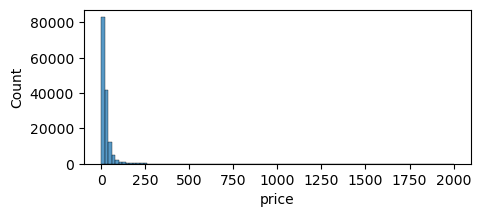

In [100]:
# 회귀문제의 타겟값은 정규분포를 띄어야함. 정규성 확인 후 정규화 진행
# log1p 로그 정규화의 장점은 expm1 로 원복이 쉬움. 

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

y_train_df = mercari_df['price']
plt.figure(figsize=(5,2))
sns.histplot(y_train_df, bins=100)
plt.show()

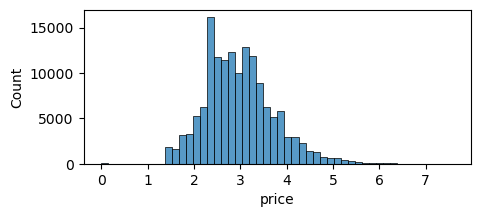

In [101]:
y_train_df = np.log1p(y_train_df)
plt.figure(figsize=(5,2))
sns.histplot(y_train_df, bins=50)
plt.show()

# 정규화 진행
mercari_df['price'] = np.log1p(mercari_df['price'])

In [102]:
# Categorical 변수들 분포 확인. 
print(mercari_df['shipping'].value_counts(), 
      mercari_df['item_condition_id'].value_counts(), sep='\n')

0    82071
1    66182
Name: shipping, dtype: int64
1    64183
3    42936
2    37730
4     3173
5      231
Name: item_condition_id, dtype: int64


In [103]:
# category_name 컬럼은 '/' 두개로 분리된 형식의 텍스트
# / 를 기준으로 대,중,소 카테고리로 나눠주는 함수 생성

# 혹시 category_name 컬럼에 '/'가 포함안된게 있는지 확인. 
non_slash = mercari_df[mercari_df['category_name'].apply(lambda x: '/' not in str(x))]
print(non_slash['category_name'].value_counts())

# / 를 기준으로 대,중,소 카테고리로 나눠주는 함수 생성
def split_cat(category_name):
    try:
        if category_name.count('/') !=2:
            return ['Other_Null' , 'Other_Null' , 'Other_Null']
        else: 
            return category_name.split('/')
    except:
        return ['Other_Null' , 'Other_Null' , 'Other_Null']

Other_Null    641
Name: category_name, dtype: int64


In [104]:
# 위의 split_cat( )을 apply lambda에서 호출하여 대,중,소 컬럼을 mercari_df에 생성.

split_result = mercari_df['category_name'].apply(lambda x : split_cat(x))

# split_result 는 3개의 원소를 가진 리스트 148253개의 시리즈. 
# zip(*split_result) 은 3개 원소를가진 리스트 148253개를 1,2,3번째 원소들끼리 묶은 튜플(148253길이의) 3개로 반환함.     
mercari_df['cat_dae'], mercari_df['cat_jung'], mercari_df['cat_so'] = \
                        zip(*split_result)

In [105]:
# 대분류만 값의 유형과 건수를 살펴보고, 중분류, 소분류는 값의 유형이 많으므로 분류 갯수만 추출
print('대분류 유형 :\n', mercari_df['cat_dae'].value_counts())
print('중분류 갯수 :', mercari_df['cat_jung'].nunique())
print('소분류 갯수 :', mercari_df['cat_so'].nunique())

대분류 유형 :
 Women                     66627
Beauty                    20884
Kids                      17036
Electronics               11736
Men                        9367
Home                       6732
Vintage & Collectibles     4698
Other                      4570
Handmade                   3077
Sports & Outdoors          2461
Other_Null                 1065
Name: cat_dae, dtype: int64
중분류 갯수 : 114
소분류 갯수 : 735


2. 피처 인코딩 & 피처 벡터화
- 텍스트 형식의 피쳐들은 인코딩(원-핫) 할지 벡터화 할것을 먼저 구분함. 
- 데이터의 종류가 너무 많으면 벡터화를 진행 (인코딩 시 피쳐가 너무 많고 희소해지면), 허용 가능한 수준이면 원핫 인코딩을 진행.
- 데이터의 종류가 거의 고유값 수준으로 많은 경우 (ex. 레코드 개수의 80%) 인코딩하면 의미가 없지만 벡터화를 하면, 긴 텍스트 안에서 의미있는 정보를 추출 가능. 
- 피쳐 벡터화의 경우 짧은 텍스트는 Count기반, 긴 텍스트는 TF-IDF 기반으로 벡터화한다. 

In [106]:
# branmd_name 피쳐는 종류가 많지 않고, 명료한 문자열이기에 인코딩 대상으로 선정
print('brand name 의 유형 건수 :', mercari_df['brand_name'].nunique())
print('brand name sample 5건 : \n', mercari_df['brand_name'].value_counts()[:5])

# 앞선 대/중/소 분류한 category_name 피처도 종류가 많지 않기에 원핫인코딩 적용
for i in ['cat_dae','cat_jung','cat_so']:
    print(i,mercari_df[i].nunique(),'---', sep='\n')

brand name 의 유형 건수 : 2321
brand name sample 5건 : 
 Other_Null           62991
PINK                  5357
Nike                  5331
Victoria's Secret     4786
LuLaRoe               3123
Name: brand_name, dtype: int64
cat_dae
11
---
cat_jung
114
---
cat_so
735
---


In [107]:
# name 컬럼은 종류가 너무 많고, 텍스트가 다소 적은 단어뭉치로 되어있기에 Count기반 벡터화를 진행.

print('name 의 종류 갯수 :', mercari_df['name'].nunique())
print('name sample 5건 : \n', mercari_df['name'][:5])

name 의 종류 갯수 : 137558
name sample 5건 : 
 0                        Hero 77 fountain pen
1                    14K Yellow Gold Earrings
2    New balance 2-in 1 size S dry fit shorts
3     Zella black workout tank w mesh cut out
4         NWT Lilly Pulitzer gabby dress sz 8
Name: name, dtype: object


In [108]:
# item_description 컬럼은 종류가 너무 많고, 텍스트의 길이 또한 길기 때문에 TF-IDF 기반의 피쳐벡터화를 진행

pd.set_option('max_colwidth', 200) #DataFrame 열 최대 넓이 직정
print('descript의 종류 갯수 :', mercari_df['item_description'].nunique())

# item_description의 평균 문자열 개수
print('item_description 평균 문자열 개수:',mercari_df['item_description'].str.len().mean())
mercari_df['item_description'][:2]

descript의 종류 갯수 : 133753
item_description 평균 문자열 개수: 146.3439120962139


0    For sale a brand new Hero 77 fountain pen, does not include the ink.
1                       14k black Onyx earrings Good condition Final sale
Name: item_description, dtype: object

In [109]:
# 피쳐의 인코딩 및 벡터화 실행
from sklearn.feature_extraction.text import CountVectorizer , TfidfVectorizer

# name 속성에 대한 Count기반 feature vectorization 변환. 
cnt_vec = CountVectorizer()
X_name = cnt_vec.fit_transform(mercari_df.name)

# item_description 에 대한 feature vectorization 변환
tfidf_descp = TfidfVectorizer(max_features = 50000, ngram_range= (1,3) , stop_words='english')
X_descp = tfidf_descp.fit_transform(mercari_df['item_description'])

# Vectorizer로 반환된 X_name, X_descp 은 CSR 형식의 희소행렬
# 벡터화된 피쳐의 개수가 10만개 이상의 희소행렬 형태이기 때문에 
# X_name, X_descp은 앞으로 인코딩할 cateogry, brand_name 등의 피쳐들과 같이 결합하여 데이터셋으로 재구성해야함. 
print(X_name.shape, X_descp.shape)
# Dense 행렬로 변환해서 보기 
print(X_name.toarray())

(148253, 31497) (148253, 50000)
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [110]:
# 희소행렬 형식으로 원핫인코딩하기. 벡터화된 피쳐들과 결합하기 위해. 
# 사이킷런의 원핫 인코딩 클래스 종류는 OneHotEncoder / LabelBinarizer 두개이고, 각각 반환값이 밀집/희소행렬로 다름.

from sklearn.preprocessing import LabelBinarizer

# brand_name, item_condition_id, shipping 각 피처들을 희소 행렬 원-핫 인코딩 변환
lb_brand_name= LabelBinarizer(sparse_output=True)
X_brand = lb_brand_name.fit_transform(mercari_df['brand_name'])

lb_item_cond_id = LabelBinarizer(sparse_output=True)
X_item_cond_id = lb_item_cond_id.fit_transform(mercari_df['item_condition_id'])

lb_shipping= LabelBinarizer(sparse_output=True)
X_shipping = lb_shipping.fit_transform(mercari_df['shipping'])

# cat_dae, cat_jung, cat_so 각 피처들을 희소 행렬 원-핫 인코딩 변환
lb_cat_dae = LabelBinarizer(sparse_output=True)
X_cat_dae= lb_cat_dae.fit_transform(mercari_df['cat_dae'])

lb_cat_jung = LabelBinarizer(sparse_output=True)
X_cat_jung = lb_cat_jung.fit_transform(mercari_df['cat_jung'])

lb_cat_so = LabelBinarizer(sparse_output=True)
X_cat_so = lb_cat_so.fit_transform(mercari_df['cat_so'])

In [111]:
# 피쳐 벡터화와 원핫인코딩으로 변환한 희소행렬들을 결합

from  scipy.sparse import hstack
import gc

sparse_matrix_list = (X_name, X_descp, X_brand, X_item_cond_id,
            X_shipping, X_cat_dae, X_cat_jung, X_cat_so)

# 사이파이 sparse 모듈의 hstack 함수를 이용하여 앞에서 인코딩과 Vectorization을 수행한 데이터 셋을 모두 결합.
X_features_sparse= hstack(sparse_matrix_list).tocsr()
 
# hstack(행렬 리스트).tocsr() 의 역할은 희소행렬 리스트들을 가로로 쌓은 희소행렬로 만든 뒤 CSR 형식으로 저장한다는 의미
print(type(X_features_sparse), X_features_sparse.shape)

# 데이터 셋이 메모리를 많이 차지하므로 사용 용도가 끝났으면 바로 메모리에서 삭제.
del X_features_sparse
gc.collect() # del 변수를 해도 실제 메모리 상에 삭제가 안되기 때문에 gc(garbage collection)을 통해 메모리에서 삭제

<class 'scipy.sparse._csr.csr_matrix'> (148253, 84684)


15416

3. 회귀 모델 구축/학습/예측/평가 
- 평가함수와 학습함수를 사용자함수로 따로 만들어 놓고, 여러가지 모델로 학습/예측/평가 비교해본다.

- 평가함수 만들기

평가지표는 RMSLE (낮은 가격보다 높은가격에서 상대적으로 더 오류가 커지는 것 방지)
타겟값인 price를 이미 log변환해뒀기 때문에 RMSLE 적용전에 expm1로 데이터 원복후 적용해야함

In [112]:
def rmsle(y , y_pred):
    # underflow, overflow를 막기 위해 log가 아닌 log1p로 rmsle 계산
    return np.sqrt(np.mean(np.power(np.log1p(y) - np.log1p(y_pred), 2)))

def evaluate_org_price(y_test , preds):

    # 원본 데이터는 log1p로 변환되었으므로 exmpm1으로 원복 필요.
    preds_exmpm = np.expm1(preds)
    y_test_exmpm = np.expm1(y_test)
   
    # rmsle로 RMSLE 값 추출
    rmsle_result = rmsle(y_test_exmpm, preds_exmpm)
    return rmsle_result

- 학습/예측 함수 만들기

model 에는 estimator를, matrix_list 에는 결합해야하는 희소행렬리스트를 입력한다. 
결합된 희소행렬 피쳐데이터와, 기존 라벨을 이용해 입력된 회귀모델로 예측된 값과 테스트 라벨을 반환한다. 

In [113]:
def model_train_predict(model,matrix_list):
    # scipy.sparse 모듈의 hstack 을 이용하여 sparse matrix 결합
    X= hstack(matrix_list).tocsr()
    
    X_train, X_test, y_train, y_test=train_test_split(X, mercari_df['price'],
                                                      test_size=0.2, random_state=156)
   
    # 모델 학습 및 예측
    model.fit(X_train , y_train)
    preds = model.predict(X_test)
   
    # 메모리를 위해 다 쓴 원본데이터는 삭제해줌
    del X , X_train , X_test , y_train
    gc.collect()
   
    return preds , y_test

In [114]:
# Ridge regression 모델을 통한 학습/예측/평가 진행. Item_Description 을 빼고도 평가했을 때 필요한 피쳐임을 알 수 있음

linear_model = Ridge(solver = "lsqr", fit_intercept=False)

sparse_matrix_list = (X_name, X_brand, X_item_cond_id,
                      X_shipping, X_cat_dae, X_cat_jung, X_cat_so)
linear_preds , y_test = model_train_predict(model=linear_model ,matrix_list=sparse_matrix_list)
print('Item Description을 제외했을 때 rmsle 값:', evaluate_org_price(y_test , linear_preds))

sparse_matrix_list = (X_descp, X_name, X_brand, X_item_cond_id,
                      X_shipping, X_cat_dae, X_cat_jung, X_cat_so)
linear_preds , y_test = model_train_predict(model=linear_model , matrix_list=sparse_matrix_list)
print('Item Description을 포함한 rmsle 값:',  evaluate_org_price(y_test ,linear_preds))

Item Description을 제외했을 때 rmsle 값: 0.5264897702248893
Item Description을 포함한 rmsle 값: 0.5089966934298036


In [115]:
from lightgbm import LGBMRegressor

sparse_matrix_list = (X_descp, X_name, X_brand, X_item_cond_id,
                      X_shipping, X_cat_dae, X_cat_jung, X_cat_so)

lgbm_model = LGBMRegressor(n_estimators=200, learning_rate=0.5, num_leaves=125, random_state=156)
lgbm_preds , y_test = model_train_predict(model = lgbm_model , matrix_list=sparse_matrix_list)
print('LightGBM rmsle 값:',  evaluate_org_price(y_test , lgbm_preds))

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 3.499088 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 553321
[LightGBM] [Info] Number of data points in the train set: 118602, number of used features: 21184
[LightGBM] [Info] Start training from score 2.980698
LightGBM rmsle 값: 0.526838672128522


In [116]:
# 서로다른 두개의 회귀모델을 가중평균하는 간단한 앙상블로 성늘 향상 만듬
# (회귀에서는 이렇게 가중평균으로도 간단한 앙상블을 수행하기도함,가중 비율에 대한 기준은 없음. 주로 성능높은 모델의 가중을 높임) 
 
preds = lgbm_preds * 0.45 + linear_preds * 0.55
print('LightGBM과 Ridge를 ensemble한 최종 rmsle 값:',  evaluate_org_price(y_test , preds))

LightGBM과 Ridge를 ensemble한 최종 rmsle 값: 0.4898128519636576
